In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = np.load('gan-checks-tf.npz')

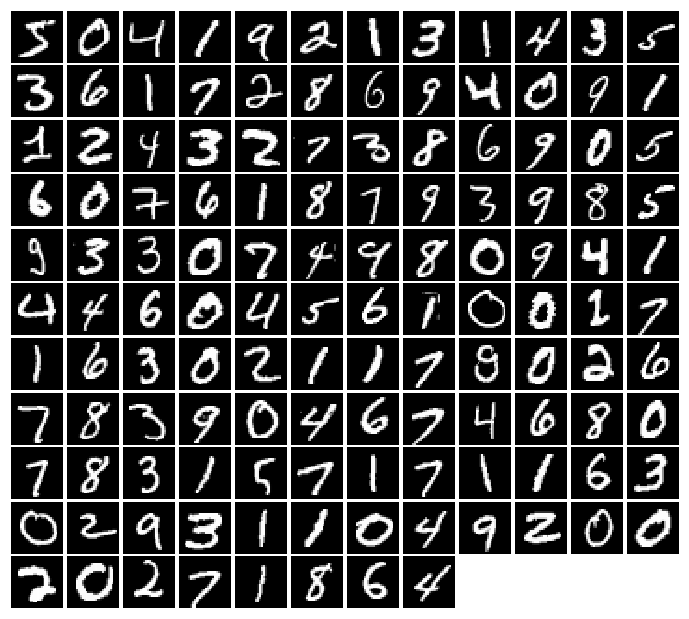

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [93]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [4]:
dtype = torch.cuda.FloatTensor

In [94]:
MaskedGenerator_V2 = nn.Sequential(nn.Conv2d(2, 32, 3, padding=1), nn.LeakyReLU(),
                                   nn.MaxPool2d(2),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.LeakyReLU(),
                                   nn.MaxPool2d(2),
                                   Flatten(),
                                   torch.nn.Linear(64*7*7, 60), # BOTTLENECK
                                   torch.nn.Linear(60, 7*7*128), torch.nn.ReLU(),
                                   torch.nn.BatchNorm1d(7*7*128),
                                   Unflatten(),
                                   torch.nn.ConvTranspose2d(128, 64, 4, 2, 1), torch.nn.ReLU(),
                                   torch.nn.BatchNorm2d(64),
                                   torch.nn.ConvTranspose2d(64, 1, 4, 2, 1), torch.nn.Tanh())

In [151]:
class MaskedGenerator_V3(nn.Module):
    def __init__(self, replace=True):
        super().__init__()
        self.replace = replace
        self.dense = nn.Sequential(nn.Conv2d(2, 32, 3, padding=1), nn.LeakyReLU(),
                                   nn.MaxPool2d(2),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.LeakyReLU(),
                                   nn.MaxPool2d(2),
                                   Flatten(),
                                   torch.nn.Linear(64*7*7, 60), # BOTTLENECK
                                   torch.nn.Linear(60, 7*7*128), torch.nn.ReLU(),
                                   torch.nn.BatchNorm1d(7*7*128),
                                   Unflatten(),
                                   torch.nn.ConvTranspose2d(128, 64, 4, 2, 1), torch.nn.ReLU(),
                                   torch.nn.BatchNorm2d(64),
                                   torch.nn.ConvTranspose2d(64, 1, 4, 2, 1), torch.nn.Tanh())
    
    def forward(self, x):
        z = self.dense(x)
        if self.replace:
            tmp_mask = x[:, [0], :, :]
            z = z*(1 - tmp_mask) + x[:, [1], :, :] * tmp_mask
        return z

In [6]:
class AddMask:
    def __init__(self, mask_size=5, n_masks=2, mask_shape=(28, 28), mask_bounds=(10, 20)):
        self.mask_size = mask_size
        self.n_masks = n_masks
        self.mask_shape = mask_shape
        self.mask_bounds = mask_bounds
    
    def _generate_mask(self):
        mask = torch.zeros(*self.mask_shape)
        for i in range(self.n_masks):
            corners = np.random.randint(*self.mask_bounds, 2)
            mask[corners[0]:corners[0]+self.mask_size, corners[1]:corners[1]+self.mask_size] = 1
        return mask
        
    def __call__(self, sample):
        default_shape = sample.size()
        mask = self._generate_mask()
        sample_outp = sample.view(*self.mask_shape)*mask + torch.rand(*self.mask_shape
                                                                     )*(1-mask)
        return (torch.stack([mask, sample_outp]), sample)

In [7]:
# as it was done here:
mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.Compose([T.ToTensor(), AddMask()]))
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.Compose([T.ToTensor(), AddMask()]))
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [152]:
mynet = MaskedGenerator_V3().cuda()

In [153]:
tmp_X = loader_train.__iter__().next()[0][0]
qu = mynet(Variable(tmp_X).cuda())

In [49]:
def show_masked_images(images, masks):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, (img, mask) in enumerate(zip(images, masks.data.cpu().numpy())):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
        plt.imshow(mask, cmap='RdGy', alpha=0.5)
    return 

In [65]:
def masked_ae_loss(batch_input, batch_output):
    batchsize = batch_input.size(0)
    before = batch_input[:,1,:,:] * batch_input[:,0,:,:]
    after = batch_output[:,0,:,:] * batch_input[:,0,:,:]
    
    return torch.nn.functional.mse_loss(before, after)

In [14]:
bce_logits = nn.BCEWithLogitsLoss()

In [15]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    loss = (bce_logits(logits_real, torch.ones_like(logits_real)) 
         + bce_logits(logits_fake, torch.zeros_like(logits_fake)))
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    loss = bce_logits(logits_fake, torch.ones_like(logits_fake))
    return loss

In [32]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        torch.nn.Conv2d(1, 32, 5, 1), torch.nn.LeakyReLU(0.01),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(32, 64, 5, 1), torch.nn.LeakyReLU(0.01),
        torch.nn.MaxPool2d(2),
        Flatten(),
        torch.nn.Linear(4*4*64, 4*4*64), torch.nn.LeakyReLU(0.01),
        torch.nn.Linear(4*4*64, 1)
    )

In [105]:
tn = lambda x: x.data.cpu().numpy()

In [162]:
def run_a_own_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10, print_every=100, alpha=1, beta=1):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, r), y in loader_train:
#             print(iter_count)
#             if len(x) != batch_size:
#                 continue
            D_solver.zero_grad()
            real_data = Variable(r).type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(x.type(dtype))
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images)

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(x).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images)
            g_error = generator_loss(gen_logits_fake)
            g_ae_part = masked_ae_loss(g_fake_seed, fake_images)
            g_loss = beta*g_error + alpha*g_ae_part
            g_loss.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_masked_images(imgs_numpy[0:16], g_fake_seed[0:16, 0, :, :])
                show_masked_images(x[0:16, 1, :, :].cpu().numpy(), g_fake_seed[0:16, 0, :, :])
                show_masked_images(r[0:16, 0, :, :].cpu().numpy(), g_fake_seed[0:16, 0, :, :])
                plt.show()
                print()
            if (iter_count % print_every == 0):
                print('Iter: {}, ae-loss: {:.3}; gen-loss: {:.3}; dis-loss: {:.3}'.format(iter_count, 
                                                                                          tn(g_ae_part)[0], 
                                                                                          tn(g_error)[0], 
                                                                                          tn(d_total_error)[0]))
            iter_count += 1

Iter: 0, D: 1.337, G:0.6197


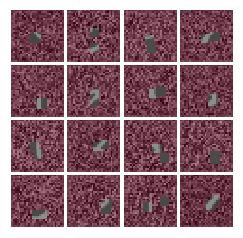

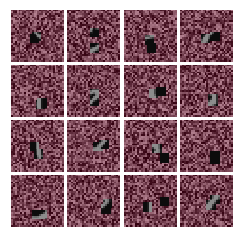

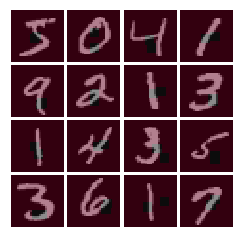


ae-loss: 0.0; gen-loss: 0.62; dis-loss: 1.34
ae-loss: 0.0; gen-loss: 4.97; dis-loss: 0.261
ae-loss: 0.0; gen-loss: 3.08; dis-loss: 0.306
ae-loss: 0.0; gen-loss: 2.05; dis-loss: 0.271
ae-loss: 0.0; gen-loss: 5.12; dis-loss: 0.205
ae-loss: 0.0; gen-loss: 4.61; dis-loss: 0.253
ae-loss: 0.0; gen-loss: 3.49; dis-loss: 0.22
ae-loss: 0.0; gen-loss: 4.98; dis-loss: 0.214
ae-loss: 0.0; gen-loss: 1.9; dis-loss: 0.813
ae-loss: 0.0; gen-loss: 4.31; dis-loss: 0.203
ae-loss: 0.0; gen-loss: 5.03; dis-loss: 0.333
ae-loss: 0.0; gen-loss: 3.57; dis-loss: 0.188
ae-loss: 0.0; gen-loss: 2.59; dis-loss: 0.507
ae-loss: 0.0; gen-loss: 2.26; dis-loss: 0.66
ae-loss: 0.0; gen-loss: 3.97; dis-loss: 0.277
ae-loss: 0.0; gen-loss: 4.67; dis-loss: 0.444
ae-loss: 0.0; gen-loss: 5.5; dis-loss: 0.16
ae-loss: 0.0; gen-loss: 2.41; dis-loss: 0.406
ae-loss: 0.0; gen-loss: 3.22; dis-loss: 0.26
ae-loss: 0.0; gen-loss: 4.47; dis-loss: 0.13
Iter: 1000, D: 0.2678, G:4.165


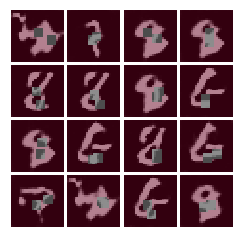

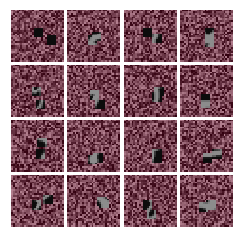

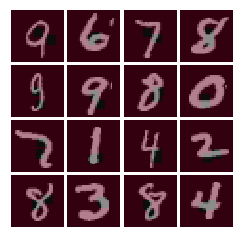


ae-loss: 0.0; gen-loss: 4.17; dis-loss: 0.268
ae-loss: 0.0; gen-loss: 3.85; dis-loss: 0.211
ae-loss: 0.0; gen-loss: 5.17; dis-loss: 0.1
ae-loss: 0.0; gen-loss: 5.74; dis-loss: 0.287
ae-loss: 0.0; gen-loss: 5.91; dis-loss: 0.195
ae-loss: 0.0; gen-loss: 6.89; dis-loss: 0.105
ae-loss: 0.0; gen-loss: 4.53; dis-loss: 0.224
ae-loss: 0.0; gen-loss: 4.48; dis-loss: 0.289
ae-loss: 0.0; gen-loss: 4.61; dis-loss: 0.16
ae-loss: 0.0; gen-loss: 5.71; dis-loss: 0.0902
ae-loss: 0.0; gen-loss: 4.83; dis-loss: 0.294
ae-loss: 0.0; gen-loss: 3.8; dis-loss: 0.274
ae-loss: 0.0; gen-loss: 4.8; dis-loss: 0.2
ae-loss: 0.0; gen-loss: 6.25; dis-loss: 0.108
ae-loss: 0.0; gen-loss: 5.97; dis-loss: 0.12
ae-loss: 0.0; gen-loss: 5.0; dis-loss: 0.109
ae-loss: 0.0; gen-loss: 4.1; dis-loss: 0.18
ae-loss: 0.0; gen-loss: 4.46; dis-loss: 0.356
ae-loss: 0.0; gen-loss: 5.08; dis-loss: 0.0986
ae-loss: 0.0; gen-loss: 5.67; dis-loss: 0.0766
Iter: 2000, D: 0.07385, G:5.144


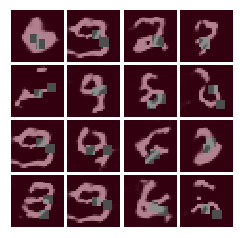

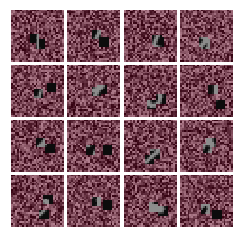

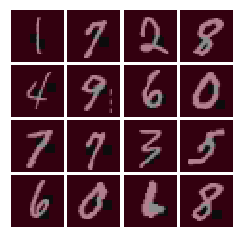


ae-loss: 0.0; gen-loss: 5.14; dis-loss: 0.0738
ae-loss: 0.0; gen-loss: 5.6; dis-loss: 0.11
ae-loss: 0.0; gen-loss: 4.99; dis-loss: 0.133
ae-loss: 0.0; gen-loss: 6.18; dis-loss: 0.12
ae-loss: 0.0; gen-loss: 7.39; dis-loss: 0.101
ae-loss: 0.0; gen-loss: 6.21; dis-loss: 0.134
ae-loss: 0.0; gen-loss: 6.2; dis-loss: 0.0854
ae-loss: 0.0; gen-loss: 6.99; dis-loss: 0.11
ae-loss: 0.0; gen-loss: 5.08; dis-loss: 0.138
ae-loss: 0.0; gen-loss: 5.64; dis-loss: 0.0841
ae-loss: 0.0; gen-loss: 5.48; dis-loss: 0.153
ae-loss: 0.0; gen-loss: 6.08; dis-loss: 0.0955
ae-loss: 0.0; gen-loss: 6.71; dis-loss: 0.105
ae-loss: 0.0; gen-loss: 8.88; dis-loss: 0.0823
ae-loss: 0.0; gen-loss: 5.98; dis-loss: 0.0903
ae-loss: 0.0; gen-loss: 7.29; dis-loss: 0.0714
ae-loss: 0.0; gen-loss: 4.19; dis-loss: 0.13
ae-loss: 0.0; gen-loss: 7.26; dis-loss: 0.0844
ae-loss: 0.0; gen-loss: 5.32; dis-loss: 0.121
ae-loss: 0.0; gen-loss: 5.09; dis-loss: 0.126
Iter: 3000, D: 0.05051, G:6.026


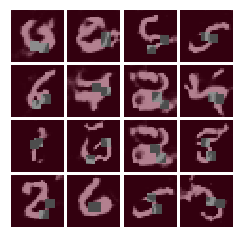

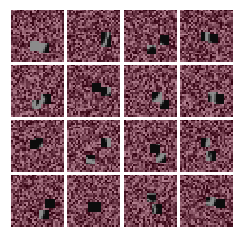

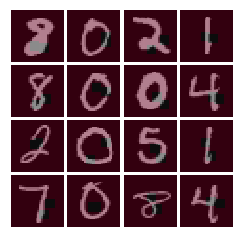


ae-loss: 0.0; gen-loss: 6.03; dis-loss: 0.0505
ae-loss: 0.0; gen-loss: 7.6; dis-loss: 0.0816
ae-loss: 0.0; gen-loss: 5.64; dis-loss: 0.101
ae-loss: 0.0; gen-loss: 6.57; dis-loss: 0.279
ae-loss: 0.0; gen-loss: 7.22; dis-loss: 0.102
ae-loss: 0.0; gen-loss: 6.78; dis-loss: 0.0622
ae-loss: 0.0; gen-loss: 4.71; dis-loss: 0.0959
ae-loss: 0.0; gen-loss: 5.14; dis-loss: 0.228
ae-loss: 0.0; gen-loss: 5.26; dis-loss: 0.178
ae-loss: 0.0; gen-loss: 7.09; dis-loss: 0.076
ae-loss: 0.0; gen-loss: 4.47; dis-loss: 0.111
ae-loss: 0.0; gen-loss: 7.18; dis-loss: 0.0493
ae-loss: 0.0; gen-loss: 5.47; dis-loss: 0.139
ae-loss: 0.0; gen-loss: 8.09; dis-loss: 0.0501
ae-loss: 0.0; gen-loss: 7.18; dis-loss: 0.0886
ae-loss: 0.0; gen-loss: 6.03; dis-loss: 0.131
ae-loss: 0.0; gen-loss: 9.69; dis-loss: 0.0271
ae-loss: 0.0; gen-loss: 6.02; dis-loss: 0.0972
ae-loss: 0.0; gen-loss: 5.69; dis-loss: 0.0784
ae-loss: 0.0; gen-loss: 6.36; dis-loss: 0.0431
Iter: 4000, D: 0.09151, G:5.828


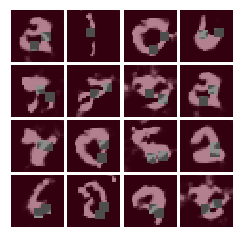

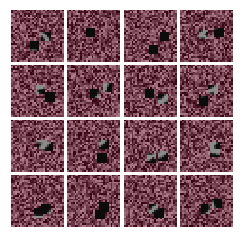

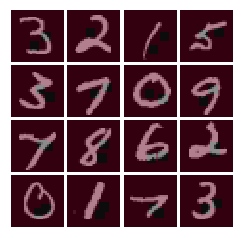


ae-loss: 0.0; gen-loss: 5.83; dis-loss: 0.0915
ae-loss: 0.0; gen-loss: 7.68; dis-loss: 0.0278
ae-loss: 0.0; gen-loss: 8.05; dis-loss: 0.0681
ae-loss: 0.0; gen-loss: 9.13; dis-loss: 0.0415
ae-loss: 0.0; gen-loss: 7.99; dis-loss: 0.139
ae-loss: 0.0; gen-loss: 8.47; dis-loss: 0.0202
ae-loss: 0.0; gen-loss: 8.49; dis-loss: 0.0507
ae-loss: 0.0; gen-loss: 5.19; dis-loss: 0.0902
ae-loss: 0.0; gen-loss: 8.96; dis-loss: 0.0453
ae-loss: 0.0; gen-loss: 9.05; dis-loss: 0.0143
ae-loss: 0.0; gen-loss: 5.75; dis-loss: 0.107
ae-loss: 0.0; gen-loss: 8.34; dis-loss: 0.087
ae-loss: 0.0; gen-loss: 10.8; dis-loss: 0.0701
ae-loss: 0.0; gen-loss: 9.56; dis-loss: 0.0325
ae-loss: 0.0; gen-loss: 9.28; dis-loss: 0.0881
ae-loss: 0.0; gen-loss: 6.83; dis-loss: 0.0993
ae-loss: 0.0; gen-loss: 9.45; dis-loss: 0.0219
ae-loss: 0.0; gen-loss: 9.89; dis-loss: 0.0405
ae-loss: 0.0; gen-loss: 8.23; dis-loss: 0.0359
ae-loss: 0.0; gen-loss: 9.32; dis-loss: 0.107
Iter: 5000, D: 0.07965, G:8.017


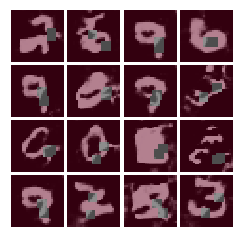

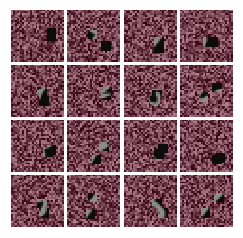

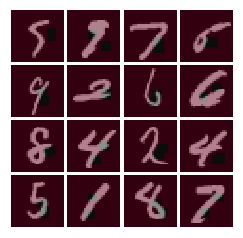


ae-loss: 0.0; gen-loss: 8.02; dis-loss: 0.0797
ae-loss: 0.0; gen-loss: 7.88; dis-loss: 0.0311
ae-loss: 0.0; gen-loss: 9.79; dis-loss: 0.0792
ae-loss: 0.0; gen-loss: 7.25; dis-loss: 0.057
ae-loss: 0.0; gen-loss: 10.5; dis-loss: 0.0231
ae-loss: 0.0; gen-loss: 9.51; dis-loss: 0.0234
ae-loss: 0.0; gen-loss: 11.1; dis-loss: 0.00719
ae-loss: 0.0; gen-loss: 7.94; dis-loss: 0.0722
ae-loss: 0.0; gen-loss: 10.7; dis-loss: 0.043
ae-loss: 0.0; gen-loss: 11.4; dis-loss: 0.00949
ae-loss: 0.0; gen-loss: 9.4; dis-loss: 0.0171
ae-loss: 0.0; gen-loss: 10.2; dis-loss: 0.0249
ae-loss: 0.0; gen-loss: 10.2; dis-loss: 0.0136
ae-loss: 0.0; gen-loss: 10.4; dis-loss: 0.101
ae-loss: 0.0; gen-loss: 11.0; dis-loss: 0.0747
ae-loss: 0.0; gen-loss: 10.8; dis-loss: 0.0175
ae-loss: 0.0; gen-loss: 11.4; dis-loss: 0.0125
ae-loss: 0.0; gen-loss: 10.9; dis-loss: 0.0501


In [156]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = MaskedGenerator_V3().cuda()
G_DC.apply(initialize_weights)

D_DC_solver = torch.optim.Adam(D_DC.parameters(), 3e-4)
G_DC_solver = torch.optim.Adam(G_DC.parameters(), 3e-4)

run_a_own_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train,
              num_epochs=15, show_every=1000, print_every=50, alpha=100)

In [129]:
mnist_check = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.Compose([T.ToTensor(), AddMask(mask_size=5, n_masks=10)]))
loader_check = DataLoader(mnist_check, batch_size=batch_size, 
                          sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

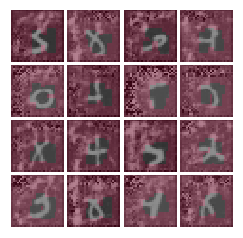

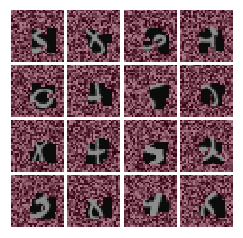

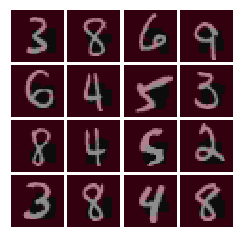

In [133]:
(tmp_X, tmp_r), tmp_y = loader_check.__iter__().next()
qu = G_DC(Variable(tmp_X).cuda())
imgs_numpy = qu.data.cpu().numpy()
tmp_mask = Variable(tmp_X[0:16, 0, :, :])
show_masked_images(imgs_numpy[0:16], tmp_mask)
show_masked_images(tmp_X[0:16, 1, :, :].cpu().numpy(), tmp_mask)
show_masked_images(tmp_r[0:16, 0, :, :].cpu().numpy(), tmp_mask)
plt.show()

Iter: 0, D: 0.007453, G:8.969


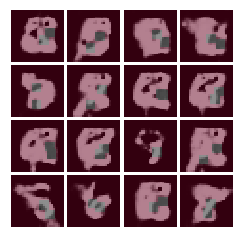

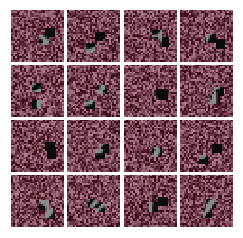

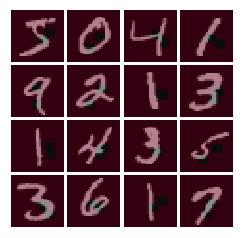


ae-loss: 0.00151; gen-loss: 8.97; dis-loss: 0.00745
ae-loss: 0.00155; gen-loss: 7.57; dis-loss: 0.0308
ae-loss: 0.00175; gen-loss: 6.41; dis-loss: 0.0521
ae-loss: 0.00131; gen-loss: 7.85; dis-loss: 0.00608
ae-loss: 0.00168; gen-loss: 7.67; dis-loss: 0.0436
ae-loss: 0.00162; gen-loss: 6.77; dis-loss: 0.0149
ae-loss: 0.00211; gen-loss: 8.92; dis-loss: 0.00629
ae-loss: 0.00214; gen-loss: 8.57; dis-loss: 0.00406
ae-loss: 0.0017; gen-loss: 7.21; dis-loss: 0.339
ae-loss: 0.00183; gen-loss: 7.43; dis-loss: 0.00741
ae-loss: 0.0017; gen-loss: 8.51; dis-loss: 0.0381
ae-loss: 0.00155; gen-loss: 7.59; dis-loss: 0.0144
ae-loss: 0.00149; gen-loss: 5.81; dis-loss: 0.0883
ae-loss: 0.00171; gen-loss: 6.4; dis-loss: 0.0341
ae-loss: 0.00161; gen-loss: 6.78; dis-loss: 0.0259
ae-loss: 0.00248; gen-loss: 8.68; dis-loss: 0.0158
ae-loss: 0.00188; gen-loss: 8.75; dis-loss: 0.032
ae-loss: 0.00175; gen-loss: 6.4; dis-loss: 0.0636
ae-loss: 0.00191; gen-loss: 6.13; dis-loss: 0.0321
ae-loss: 0.00196; gen-loss: 8.1

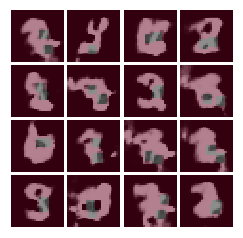

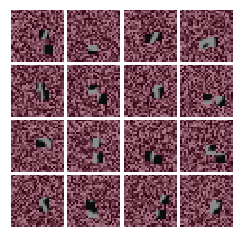

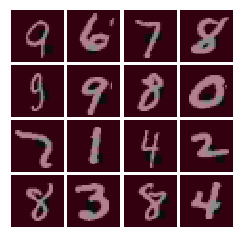


ae-loss: 0.00141; gen-loss: 8.4; dis-loss: 0.0689
ae-loss: 0.0017; gen-loss: 8.99; dis-loss: 0.0207
ae-loss: 0.00215; gen-loss: 7.85; dis-loss: 0.0095
ae-loss: 0.00177; gen-loss: 8.3; dis-loss: 0.0143
ae-loss: 0.002; gen-loss: 7.63; dis-loss: 0.0101
ae-loss: 0.00216; gen-loss: 11.6; dis-loss: 0.00809
ae-loss: 0.00158; gen-loss: 6.82; dis-loss: 0.0456
ae-loss: 0.0014; gen-loss: 6.87; dis-loss: 0.0141
ae-loss: 0.00202; gen-loss: 8.09; dis-loss: 0.089
ae-loss: 0.00199; gen-loss: 8.69; dis-loss: 0.00698
ae-loss: 0.00166; gen-loss: 6.98; dis-loss: 0.0513
ae-loss: 0.00191; gen-loss: 7.71; dis-loss: 0.0283
ae-loss: 0.00169; gen-loss: 9.21; dis-loss: 0.18
ae-loss: 0.00194; gen-loss: 7.26; dis-loss: 0.0248
ae-loss: 0.00192; gen-loss: 7.56; dis-loss: 0.00536
ae-loss: 0.00224; gen-loss: 8.21; dis-loss: 0.0147
ae-loss: 0.00202; gen-loss: 10.2; dis-loss: 0.0316
ae-loss: 0.00164; gen-loss: 8.4; dis-loss: 0.113
ae-loss: 0.00207; gen-loss: 9.65; dis-loss: 0.0148
ae-loss: 0.00201; gen-loss: 11.0; dis-

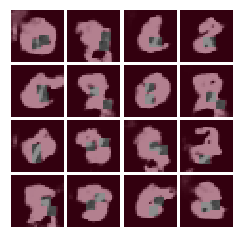

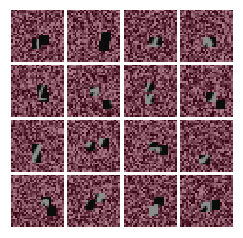

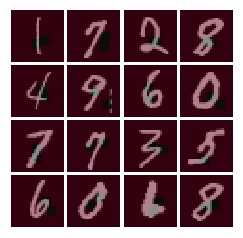


ae-loss: 0.00202; gen-loss: 8.87; dis-loss: 0.00274
ae-loss: 0.00183; gen-loss: 6.29; dis-loss: 0.032
ae-loss: 0.00184; gen-loss: 7.58; dis-loss: 0.0154
ae-loss: 0.00226; gen-loss: 6.99; dis-loss: 0.0612
ae-loss: 0.00205; gen-loss: 7.57; dis-loss: 0.00998
ae-loss: 0.00276; gen-loss: 10.2; dis-loss: 0.011
ae-loss: 0.00246; gen-loss: 9.95; dis-loss: 0.00754
ae-loss: 0.00263; gen-loss: 12.4; dis-loss: 0.0595
ae-loss: 0.00226; gen-loss: 8.85; dis-loss: 0.0246
ae-loss: 0.00186; gen-loss: 8.18; dis-loss: 0.00767
ae-loss: 0.0019; gen-loss: 7.2; dis-loss: 0.0358
ae-loss: 0.00232; gen-loss: 7.76; dis-loss: 0.0108
ae-loss: 0.00231; gen-loss: 9.17; dis-loss: 0.0258
ae-loss: 0.00225; gen-loss: 9.16; dis-loss: 0.00879
ae-loss: 0.00227; gen-loss: 9.31; dis-loss: 0.0111
ae-loss: 0.00316; gen-loss: 8.45; dis-loss: 0.0892
ae-loss: 0.00205; gen-loss: 9.0; dis-loss: 0.0169
ae-loss: 0.00242; gen-loss: 6.48; dis-loss: 0.0171
ae-loss: 0.00251; gen-loss: 9.27; dis-loss: 0.0299
ae-loss: 0.00236; gen-loss: 7.

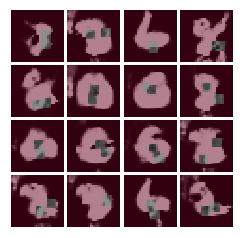

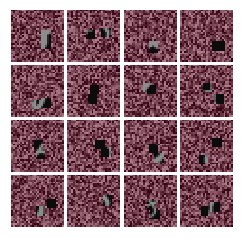

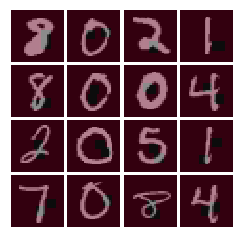


ae-loss: 0.00225; gen-loss: 9.27; dis-loss: 0.07
ae-loss: 0.00249; gen-loss: 9.6; dis-loss: 0.00223
ae-loss: 0.00286; gen-loss: 8.93; dis-loss: 0.0301
ae-loss: 0.00244; gen-loss: 9.24; dis-loss: 0.0897
ae-loss: 0.00301; gen-loss: 10.7; dis-loss: 0.016
ae-loss: 0.00241; gen-loss: 8.48; dis-loss: 0.0305
ae-loss: 0.00255; gen-loss: 7.27; dis-loss: 0.0377
ae-loss: 0.00246; gen-loss: 8.78; dis-loss: 0.0243
ae-loss: 0.00327; gen-loss: 11.2; dis-loss: 0.00632
ae-loss: 0.00304; gen-loss: 7.65; dis-loss: 0.0364
ae-loss: 0.00256; gen-loss: 6.91; dis-loss: 0.113
ae-loss: 0.00305; gen-loss: 9.15; dis-loss: 0.00945
ae-loss: 0.00346; gen-loss: 5.27; dis-loss: 0.0953
ae-loss: 0.00304; gen-loss: 9.07; dis-loss: 0.0118
ae-loss: 0.00245; gen-loss: 6.37; dis-loss: 0.0282
ae-loss: 0.00349; gen-loss: 5.97; dis-loss: 0.0301
ae-loss: 0.00375; gen-loss: 9.11; dis-loss: 0.00277
ae-loss: 0.00331; gen-loss: 7.54; dis-loss: 0.0132
ae-loss: 0.0028; gen-loss: 6.83; dis-loss: 0.0238
ae-loss: 0.00326; gen-loss: 7.14

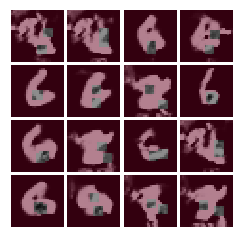

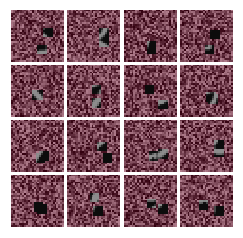

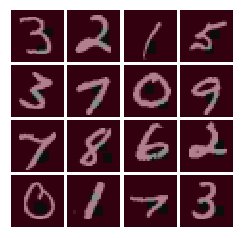


ae-loss: 0.00353; gen-loss: 7.83; dis-loss: 0.0196
ae-loss: 0.0028; gen-loss: 8.87; dis-loss: 0.00714
ae-loss: 0.00329; gen-loss: 9.48; dis-loss: 0.0307
ae-loss: 0.00385; gen-loss: 10.0; dis-loss: 0.0732
ae-loss: 0.00333; gen-loss: 7.93; dis-loss: 0.107
ae-loss: 0.00351; gen-loss: 11.2; dis-loss: 0.091
ae-loss: 0.0035; gen-loss: 11.1; dis-loss: 0.0211
ae-loss: 0.00292; gen-loss: 8.99; dis-loss: 0.0169
ae-loss: 0.00405; gen-loss: 10.3; dis-loss: 0.00307
ae-loss: 0.0037; gen-loss: 11.0; dis-loss: 0.00103
ae-loss: 0.00344; gen-loss: 9.02; dis-loss: 0.0295
ae-loss: 0.00431; gen-loss: 9.21; dis-loss: 0.0226
ae-loss: 0.00459; gen-loss: 8.49; dis-loss: 0.0274
ae-loss: 0.00426; gen-loss: 10.4; dis-loss: 0.0343
ae-loss: 0.00471; gen-loss: 8.55; dis-loss: 0.0611
ae-loss: 0.00473; gen-loss: 10.0; dis-loss: 0.00388


KeyboardInterrupt: 

In [138]:
run_a_own_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train,
              num_epochs=15, show_every=1000, print_every=50, alpha=1000)

Iter: 0, D: 1.384, G:0.5649


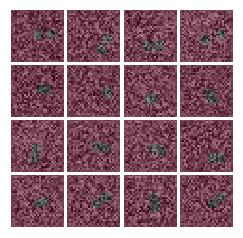

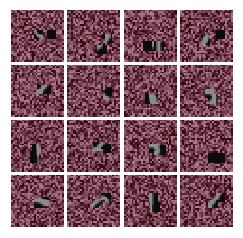

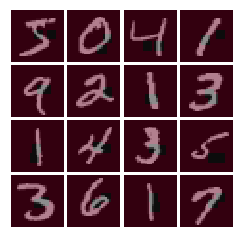


ae-loss: 0.0231; gen-loss: 0.565; dis-loss: 1.38
ae-loss: 0.0408; gen-loss: 4.29; dis-loss: 0.149
ae-loss: 0.0354; gen-loss: 3.91; dis-loss: 0.424
ae-loss: 0.0583; gen-loss: 1.31; dis-loss: 0.825
ae-loss: 0.0659; gen-loss: 3.27; dis-loss: 0.386
ae-loss: 0.0529; gen-loss: 1.97; dis-loss: 0.74
ae-loss: 0.0588; gen-loss: 2.38; dis-loss: 0.358
ae-loss: 0.0595; gen-loss: 2.89; dis-loss: 0.71
ae-loss: 0.0672; gen-loss: 0.998; dis-loss: 1.66
ae-loss: 0.0719; gen-loss: 3.19; dis-loss: 0.819
ae-loss: 0.0637; gen-loss: 2.58; dis-loss: 1.1
ae-loss: 0.0814; gen-loss: 2.79; dis-loss: 0.527
ae-loss: 0.0735; gen-loss: 2.56; dis-loss: 0.884
ae-loss: 0.0768; gen-loss: 2.75; dis-loss: 0.529
ae-loss: 0.0681; gen-loss: 1.88; dis-loss: 1.06
ae-loss: 0.0656; gen-loss: 1.75; dis-loss: 1.11
ae-loss: 0.0816; gen-loss: 2.82; dis-loss: 0.347
ae-loss: 0.0784; gen-loss: 1.57; dis-loss: 0.908
ae-loss: 0.0676; gen-loss: 2.21; dis-loss: 1.09
ae-loss: 0.0609; gen-loss: 1.88; dis-loss: 0.999
Iter: 1000, D: 0.782, G:1.

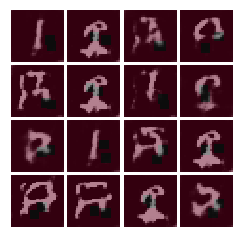

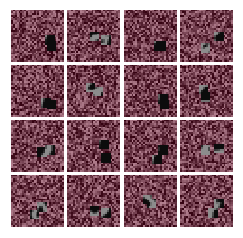

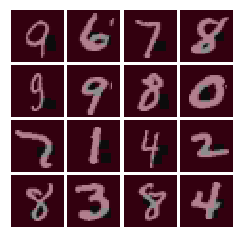


ae-loss: 0.0941; gen-loss: 1.68; dis-loss: 0.782
ae-loss: 0.076; gen-loss: 3.13; dis-loss: 0.515
ae-loss: 0.0764; gen-loss: 2.57; dis-loss: 0.612
ae-loss: 0.0668; gen-loss: 2.08; dis-loss: 0.546
ae-loss: 0.0722; gen-loss: 2.76; dis-loss: 0.561
ae-loss: 0.0748; gen-loss: 2.22; dis-loss: 0.551
ae-loss: 0.079; gen-loss: 1.79; dis-loss: 0.621
ae-loss: 0.0821; gen-loss: 2.61; dis-loss: 0.822
ae-loss: 0.0742; gen-loss: 1.85; dis-loss: 0.524
ae-loss: 0.0737; gen-loss: 1.63; dis-loss: 0.681
ae-loss: 0.0746; gen-loss: 1.85; dis-loss: 0.746
ae-loss: 0.0717; gen-loss: 1.87; dis-loss: 0.707
ae-loss: 0.0724; gen-loss: 2.39; dis-loss: 0.503
ae-loss: 0.0786; gen-loss: 1.83; dis-loss: 0.431
ae-loss: 0.0723; gen-loss: 2.65; dis-loss: 0.852
ae-loss: 0.0747; gen-loss: 3.06; dis-loss: 0.525
ae-loss: 0.0654; gen-loss: 2.26; dis-loss: 0.541
ae-loss: 0.0672; gen-loss: 2.49; dis-loss: 0.75
ae-loss: 0.0653; gen-loss: 1.81; dis-loss: 0.534
ae-loss: 0.0702; gen-loss: 2.65; dis-loss: 0.367
Iter: 2000, D: 0.7078,

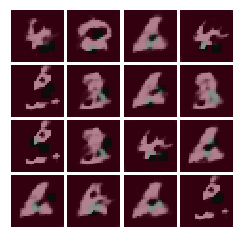

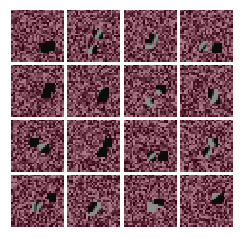

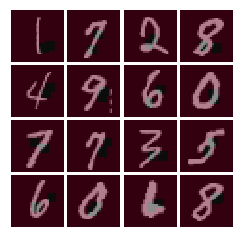


ae-loss: 0.0661; gen-loss: 1.65; dis-loss: 0.708
ae-loss: 0.0666; gen-loss: 1.72; dis-loss: 1.01
ae-loss: 0.0722; gen-loss: 1.99; dis-loss: 0.51
ae-loss: 0.073; gen-loss: 2.37; dis-loss: 0.381
ae-loss: 0.0646; gen-loss: 2.38; dis-loss: 0.61
ae-loss: 0.0668; gen-loss: 1.9; dis-loss: 0.495
ae-loss: 0.0714; gen-loss: 2.38; dis-loss: 0.489
ae-loss: 0.0643; gen-loss: 2.63; dis-loss: 0.274
ae-loss: 0.069; gen-loss: 2.11; dis-loss: 0.645
ae-loss: 0.076; gen-loss: 3.35; dis-loss: 0.293
ae-loss: 0.0741; gen-loss: 2.98; dis-loss: 0.462
ae-loss: 0.075; gen-loss: 4.15; dis-loss: 0.244
ae-loss: 0.0927; gen-loss: 2.24; dis-loss: 0.535
ae-loss: 0.071; gen-loss: 2.95; dis-loss: 0.358
ae-loss: 0.072; gen-loss: 2.82; dis-loss: 0.579
ae-loss: 0.0638; gen-loss: 2.06; dis-loss: 0.532
ae-loss: 0.0726; gen-loss: 2.21; dis-loss: 0.497
ae-loss: 0.0639; gen-loss: 2.77; dis-loss: 0.588
ae-loss: 0.0641; gen-loss: 3.24; dis-loss: 0.785
ae-loss: 0.0694; gen-loss: 3.49; dis-loss: 0.459
Iter: 3000, D: 0.8218, G:3.64

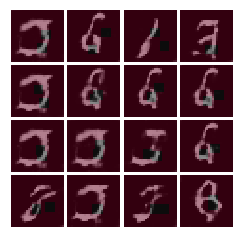

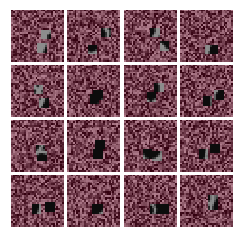

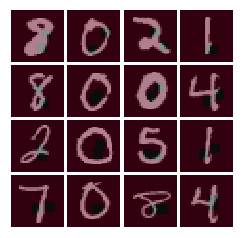


ae-loss: 0.0749; gen-loss: 3.65; dis-loss: 0.822
ae-loss: 0.0532; gen-loss: 3.05; dis-loss: 0.362
ae-loss: 0.0774; gen-loss: 4.39; dis-loss: 0.259
ae-loss: 0.0753; gen-loss: 3.32; dis-loss: 0.483
ae-loss: 0.0656; gen-loss: 3.01; dis-loss: 0.523
ae-loss: 0.0629; gen-loss: 3.09; dis-loss: 0.314
ae-loss: 0.0674; gen-loss: 1.87; dis-loss: 0.445
ae-loss: 0.0694; gen-loss: 3.12; dis-loss: 0.617
ae-loss: 0.0761; gen-loss: 1.52; dis-loss: 0.678
ae-loss: 0.0743; gen-loss: 3.16; dis-loss: 0.564
ae-loss: 0.0853; gen-loss: 2.2; dis-loss: 0.5
ae-loss: 0.0769; gen-loss: 2.65; dis-loss: 0.264
ae-loss: 0.0746; gen-loss: 1.92; dis-loss: 0.41
ae-loss: 0.0722; gen-loss: 2.46; dis-loss: 0.393
ae-loss: 0.0672; gen-loss: 2.57; dis-loss: 0.458
ae-loss: 0.0679; gen-loss: 2.38; dis-loss: 0.597
ae-loss: 0.0694; gen-loss: 3.57; dis-loss: 0.334
ae-loss: 0.0827; gen-loss: 2.15; dis-loss: 0.704
ae-loss: 0.0684; gen-loss: 1.98; dis-loss: 0.759
ae-loss: 0.0698; gen-loss: 3.46; dis-loss: 0.353
Iter: 4000, D: 0.9635, 

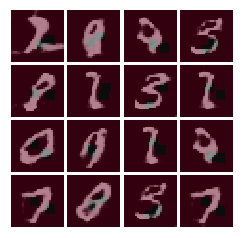

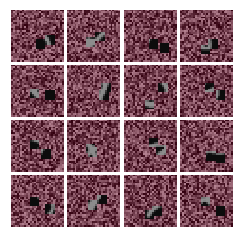

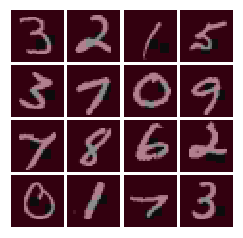


ae-loss: 0.0662; gen-loss: 2.38; dis-loss: 0.963
ae-loss: 0.0718; gen-loss: 1.93; dis-loss: 0.715
ae-loss: 0.0723; gen-loss: 2.46; dis-loss: 0.466
ae-loss: 0.0633; gen-loss: 2.73; dis-loss: 0.61
ae-loss: 0.0769; gen-loss: 2.31; dis-loss: 0.582
ae-loss: 0.0744; gen-loss: 2.21; dis-loss: 0.466
ae-loss: 0.0647; gen-loss: 2.82; dis-loss: 0.486
ae-loss: 0.0824; gen-loss: 2.65; dis-loss: 0.471
ae-loss: 0.0775; gen-loss: 2.67; dis-loss: 0.735
ae-loss: 0.0754; gen-loss: 1.94; dis-loss: 0.536
ae-loss: 0.0851; gen-loss: 2.41; dis-loss: 0.57
ae-loss: 0.0701; gen-loss: 2.53; dis-loss: 0.535
ae-loss: 0.0751; gen-loss: 2.71; dis-loss: 0.4
ae-loss: 0.0775; gen-loss: 2.22; dis-loss: 0.487
ae-loss: 0.0707; gen-loss: 2.94; dis-loss: 0.865
ae-loss: 0.0688; gen-loss: 2.62; dis-loss: 0.443
ae-loss: 0.0686; gen-loss: 1.64; dis-loss: 0.616
ae-loss: 0.0709; gen-loss: 1.79; dis-loss: 0.77
ae-loss: 0.0675; gen-loss: 2.29; dis-loss: 0.649
ae-loss: 0.0712; gen-loss: 2.19; dis-loss: 0.503
Iter: 5000, D: 0.7921, G

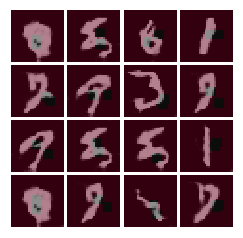

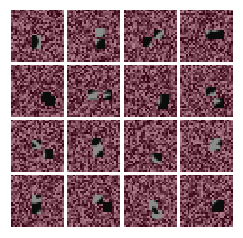

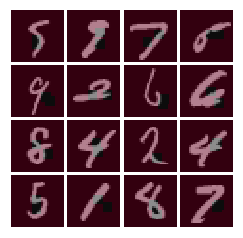


ae-loss: 0.0742; gen-loss: 2.33; dis-loss: 0.792
ae-loss: 0.0822; gen-loss: 1.79; dis-loss: 0.579
ae-loss: 0.0827; gen-loss: 1.65; dis-loss: 0.741
ae-loss: 0.081; gen-loss: 1.29; dis-loss: 0.747
ae-loss: 0.0721; gen-loss: 2.73; dis-loss: 0.637
ae-loss: 0.07; gen-loss: 2.21; dis-loss: 0.656
ae-loss: 0.063; gen-loss: 2.07; dis-loss: 0.531
ae-loss: 0.0649; gen-loss: 3.11; dis-loss: 0.352
ae-loss: 0.0669; gen-loss: 2.36; dis-loss: 0.422
ae-loss: 0.0746; gen-loss: 2.42; dis-loss: 0.472
ae-loss: 0.0633; gen-loss: 3.16; dis-loss: 0.46
ae-loss: 0.0613; gen-loss: 2.02; dis-loss: 0.533
ae-loss: 0.066; gen-loss: 2.4; dis-loss: 0.766
ae-loss: 0.0597; gen-loss: 1.84; dis-loss: 0.548
ae-loss: 0.0731; gen-loss: 2.65; dis-loss: 0.394
ae-loss: 0.0688; gen-loss: 3.19; dis-loss: 0.627
ae-loss: 0.0645; gen-loss: 2.68; dis-loss: 0.592
ae-loss: 0.0664; gen-loss: 1.79; dis-loss: 0.559


In [157]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = MaskedGenerator_V3(False).cuda()
G_DC.apply(initialize_weights)

D_DC_solver = torch.optim.Adam(D_DC.parameters(), 3e-4)
G_DC_solver = torch.optim.Adam(G_DC.parameters(), 3e-4)

run_a_own_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train,
              num_epochs=15, show_every=1000, print_every=50, alpha=0)

In [159]:
mnist_bigwindow = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.Compose([T.ToTensor(), AddMask(mask_size=10, n_masks=3)]))
loader_bigwindow = DataLoader(mnist_bigwindow, batch_size=batch_size, 
                          sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

Iter: 0, D: 1.404, G:0.6604


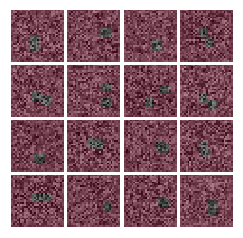

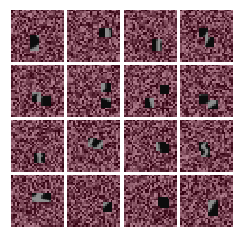

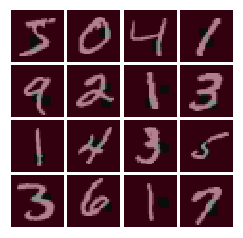


Iter: 0, ae-loss: 0.026; gen-loss: 0.66; dis-loss: 1.4
Iter: 50, ae-loss: 0.0395; gen-loss: 3.07; dis-loss: 0.19
Iter: 100, ae-loss: 0.0389; gen-loss: 2.92; dis-loss: 0.493
Iter: 150, ae-loss: 0.0498; gen-loss: 2.97; dis-loss: 0.58
Iter: 200, ae-loss: 0.0768; gen-loss: 2.95; dis-loss: 0.617
Iter: 250, ae-loss: 0.0649; gen-loss: 3.52; dis-loss: 0.912
Iter: 300, ae-loss: 0.0722; gen-loss: 1.61; dis-loss: 0.465
Iter: 350, ae-loss: 0.0629; gen-loss: 2.04; dis-loss: 0.655
Iter: 400, ae-loss: 0.0616; gen-loss: 1.19; dis-loss: 1.21
Iter: 450, ae-loss: 0.0783; gen-loss: 3.79; dis-loss: 1.13
Iter: 500, ae-loss: 0.0745; gen-loss: 2.57; dis-loss: 0.825
Iter: 550, ae-loss: 0.0544; gen-loss: 1.7; dis-loss: 0.311
Iter: 600, ae-loss: 0.0708; gen-loss: 1.87; dis-loss: 0.817
Iter: 650, ae-loss: 0.0615; gen-loss: 2.67; dis-loss: 0.719
Iter: 700, ae-loss: 0.0723; gen-loss: 2.57; dis-loss: 0.927
Iter: 750, ae-loss: 0.0747; gen-loss: 2.19; dis-loss: 0.993
Iter: 800, ae-loss: 0.0609; gen-loss: 3.62; dis-lo

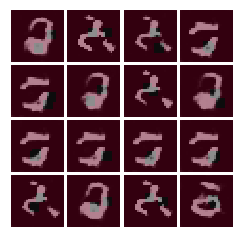

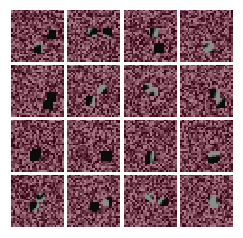

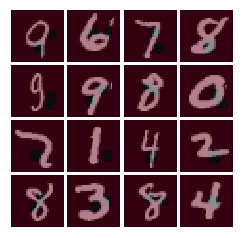


Iter: 1000, ae-loss: 0.0587; gen-loss: 1.88; dis-loss: 0.584
Iter: 1050, ae-loss: 0.0793; gen-loss: 1.98; dis-loss: 0.657
Iter: 1100, ae-loss: 0.0652; gen-loss: 2.58; dis-loss: 0.517
Iter: 1150, ae-loss: 0.081; gen-loss: 2.0; dis-loss: 0.613
Iter: 1200, ae-loss: 0.0796; gen-loss: 2.74; dis-loss: 0.593
Iter: 1250, ae-loss: 0.0854; gen-loss: 2.93; dis-loss: 0.49
Iter: 1300, ae-loss: 0.0574; gen-loss: 2.53; dis-loss: 0.479
Iter: 1350, ae-loss: 0.0879; gen-loss: 1.74; dis-loss: 1.3
Iter: 1400, ae-loss: 0.0606; gen-loss: 2.17; dis-loss: 0.646
Iter: 1450, ae-loss: 0.0695; gen-loss: 2.17; dis-loss: 0.782
Iter: 1500, ae-loss: 0.0795; gen-loss: 2.52; dis-loss: 0.826
Iter: 1550, ae-loss: 0.0727; gen-loss: 1.58; dis-loss: 1.28
Iter: 1600, ae-loss: 0.0647; gen-loss: 2.23; dis-loss: 0.908
Iter: 1650, ae-loss: 0.0705; gen-loss: 1.42; dis-loss: 0.673
Iter: 1700, ae-loss: 0.0749; gen-loss: 1.98; dis-loss: 0.624
Iter: 1750, ae-loss: 0.0728; gen-loss: 1.87; dis-loss: 0.969
Iter: 1800, ae-loss: 0.0714; 

KeyboardInterrupt: 

In [164]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = MaskedGenerator_V3(False).cuda()
G_DC.apply(initialize_weights)

D_DC_solver = torch.optim.Adam(D_DC.parameters(), 3e-4)
G_DC_solver = torch.optim.Adam(G_DC.parameters(), 3e-4)

run_a_own_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train,
              num_epochs=15, show_every=1000, print_every=50, alpha=0)